In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
import os
from os.path import join
import regress
import h5py
import csv

In [2]:
BATCH_SIZE = 35
def gen_rand_noise(): # z
    noise = torch.randn(BATCH_SIZE, 128)
    return noise


In [3]:
gen = torch.load('output/run_008_paper_J/generator.pt', map_location='cpu') 
#gen = torch.load('output/run_001_5k/generator.pt', map_location='cpu') 
#gen = torch.load('output/run_004_Jmodel/generator.pt', map_location='cpu') 
gen.eval()

regressor = regress.Net3()

regressor.load_state_dict(torch.load('fixed_balanced_J3_regressor.pt',map_location='cpu'))
#regressor.load_state_dict(torch.load('run_005_J_smoothbalancedregressor.pt',map_location='cpu'))
# regressor.load_state_dict(torch.load('run_004_J_balancedregressor.pt',map_location='cpu'))
# regressor.load_state_dict(torch.load('run_003_J_regressor.pt',map_location='cpu'))
# regressor.load_state_dict(torch.load('run_003_J_smooth_regressor.pt',map_location='cpu'))
# regressor.load_state_dict(torch.load('run_002_regressor.pt',map_location='cpu'))
regressor.eval()

params = sum(p.numel() for p in regressor.parameters() if p.requires_grad)
print('Num of params:'+ str(params))

Num of params:11119521


torch.Size([35, 1])


/home/microway/.conda/envs/SGAN/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


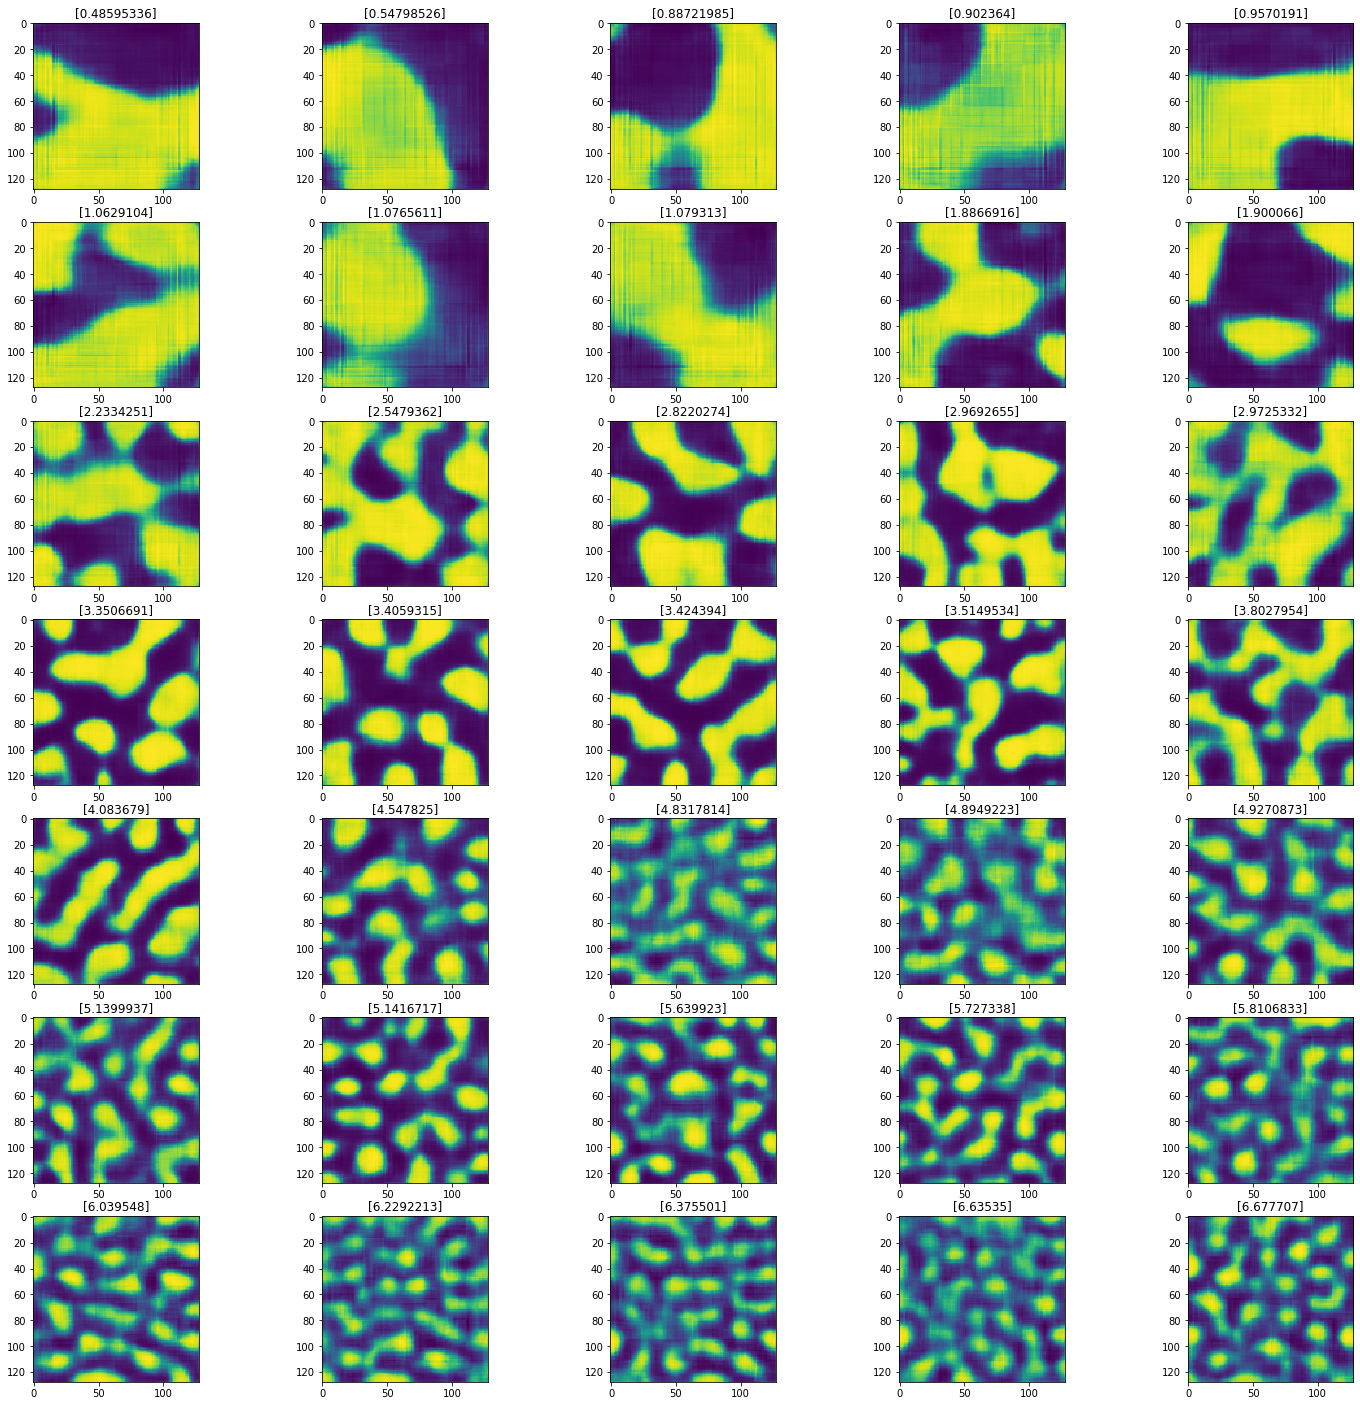

In [4]:
noise = gen_rand_noise()

Js = []
for i in range(7):
    J = np.random.uniform(low = 0.01+i, high = 1+i, size = 5)
    Js.append(J)

Js = np.expand_dims(np.ndarray.flatten(np.sort(np.asarray(Js))), axis=1)
Js = torch.FloatTensor(Js)
print(Js.shape)

#Js = torch.FloatTensor([[0.01], [0.5], [3.0], [3.2], [6.3]])

gen_img = gen(noise, Js).detach().numpy()
fig, axs = plt.subplots(7, 5, figsize=(25,25))

i=0
j=0
for i in range(7):
    
    img = np.reshape(gen_img[0+j],(128,128))
    axs[i, 0].imshow(img)
    axs[i, 0].set_title(str(Js[0+j].detach().numpy()))
    
    img = np.reshape(gen_img[1+j],(128,128))
    axs[i, 1].imshow(img)
    axs[i, 1].set_title(str(Js[1+j].detach().numpy()))
    
    img = np.reshape(gen_img[2+j],(128,128))
    axs[i, 2].imshow(img)
    axs[i, 2].set_title(str(Js[2+j].detach().numpy()))
    
    img = np.reshape(gen_img[3+j],(128,128))
    axs[i, 3].imshow(img)
    axs[i, 3].set_title(str(Js[3+j].detach().numpy()))
    
    img = np.reshape(gen_img[4+j],(128,128))
    axs[i, 4].imshow(img)
    axs[i, 4].set_title(str(Js[4+j].detach().numpy()))
    
    j+=5
    
    #ax.title.set_title(str(Js[i].detach().numpy()))
    #ax.imshow(img)
    #plt.imsave('sample_'+ str(Js[i]) + '.png', img)
    #i+=1    
    

[0.48595336079597473, 0.5479852557182312, 0.8872198462486267, 0.9023640155792236, 0.9570190906524658, 1.0629104375839233, 1.0765610933303833, 1.079313039779663, 1.8866915702819824, 1.9000660181045532, 2.2334251403808594, 2.547936201095581, 2.8220274448394775, 2.9692654609680176, 2.9725332260131836, 3.3506691455841064, 3.4059314727783203, 3.424393892288208, 3.514953374862671, 3.80279541015625, 4.08367919921875, 4.547824859619141, 4.831781387329102, 4.894922256469727, 4.927087306976318, 5.139993667602539, 5.141671657562256, 5.639923095703125, 5.727337837219238, 5.810683250427246, 6.039547920227051, 6.229221343994141, 6.3755011558532715, 6.635350227355957, 6.677707195281982]
[0.61818427 0.759763   0.8681436  0.88139516 1.0361218  1.3638879
 1.1272213  1.0621822  1.9552544  2.4927623  2.1227603  2.6499717
 2.622307   2.727616   2.944521   3.4879498  3.613509   3.7069438
 3.6232255  3.9256494  4.058792   4.568218   5.0331097  4.717894
 5.0543323  5.123018   5.327775   5.6991496  5.629737   

Text(0.5, 0, 'Design Input J')

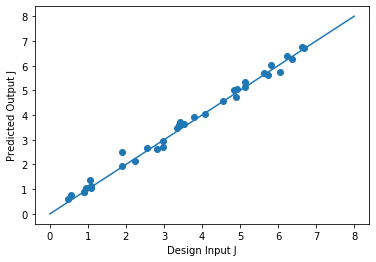

In [7]:
pred_Js = []
for i in range(35):
    gen_data = torch.FloatTensor(np.reshape(gen_img[i],(128,128)))
    gen_data = torch.unsqueeze(torch.unsqueeze(gen_data, dim=0), dim=0)
    pred_J = regressor(gen_data)
    pred_Js.append(pred_J.detach().numpy())

x = np.linspace(0,8,100)
y = x
ctrl_J = np.squeeze(Js.detach().numpy(), axis=1).tolist()
print(ctrl_J)
out_J = np.asarray(pred_Js)
print(out_J)
plt.scatter(ctrl_J, out_J)
plt.plot(x,y)
#plt.ylim(0,7)
plt.ylabel('Predicted Output J')
plt.xlabel('Design Input J')

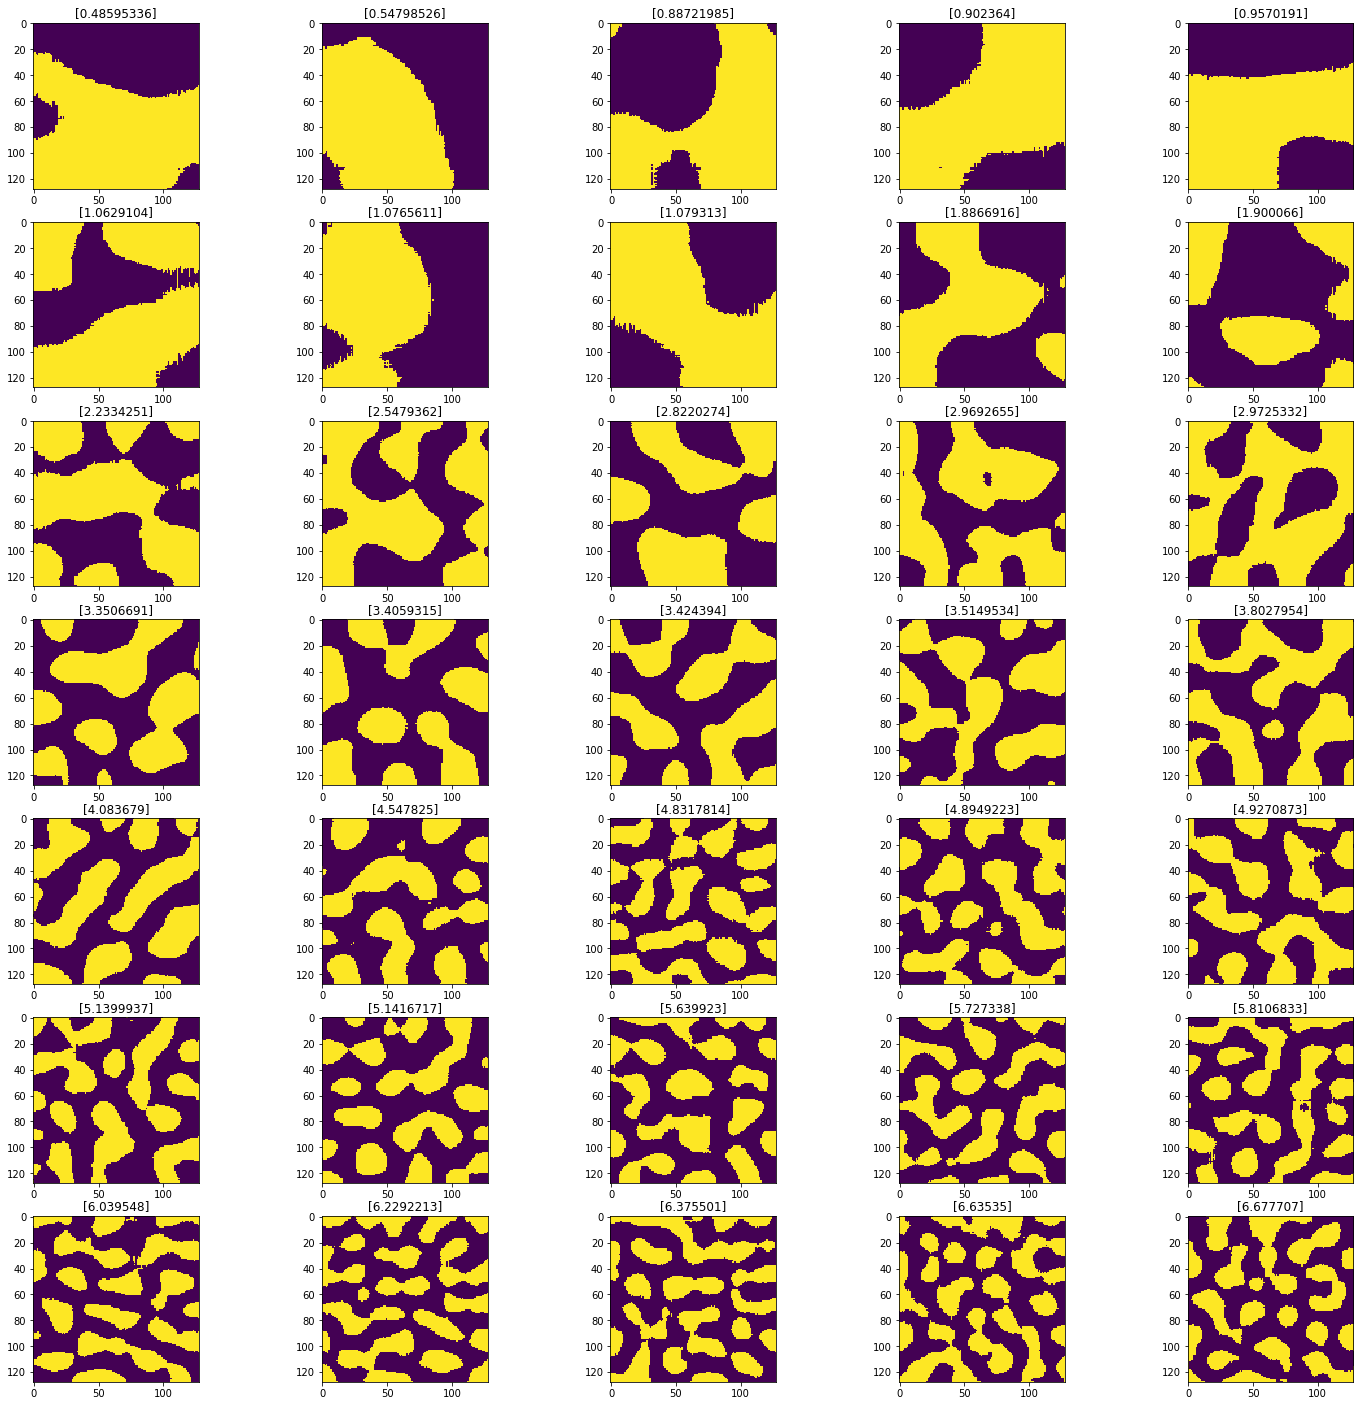

In [6]:
#binarized data for evaluation
bin_data = []
save_data = np.squeeze(gen_img, axis=1)
for i in range(save_data.shape[0]):
    
    avg = np.mean(save_data[i])
    #print(avg)
    bin_img = np.where(save_data[i] > avg, 1, 0)
    bin_data.append(bin_img)
    
bin_data = np.asarray(bin_data)

fig, axs = plt.subplots(7, 5, figsize=(25,25))

i=0
j=0
for i in range(7):
    
    axs[i, 0].imshow(bin_data[0+j])
    axs[i, 0].set_title(str(Js[0+j].detach().numpy()))

    axs[i, 1].imshow(bin_data[1+j])
    axs[i, 1].set_title(str(Js[1+j].detach().numpy()))
    
    axs[i, 2].imshow(bin_data[2+j])
    axs[i, 2].set_title(str(Js[2+j].detach().numpy()))

    axs[i, 3].imshow(bin_data[3+j])
    axs[i, 3].set_title(str(Js[3+j].detach().numpy()))

    axs[i, 4].imshow(bin_data[4+j])
    axs[i, 4].set_title(str(Js[4+j].detach().numpy()))
    
    j+=5
    

# with h5py.File('test.h5', 'w') as hf:
#     hf.create_dataset("test",  data=gen_img[0][0])
# h5_data = np.squeeze(gen_img, axis=1)
# print(h5_data.shape)
# for i in range(35):
#     with h5py.File('test_' + str(i) + '.h5', 'w') as hf:
#         hf.create_dataset("test" + str(i),  data=h5_data[i])


In [10]:
flip_data = []
for i in range(bin_data.shape[0]):
    flip = np.flip(bin_data[i], axis=0)
#     flip = np.flip(flip, axis=1)
    flip_data.append(flip)

bin_data = np.asarray(flip_data)

for num in range(35):
    f= open(str(num) + "_2_test.plt","w+")
    f.write('TITLE ="t=0.000000"\n')
    f.write('VARIABLES = "x"  "y"      "MS"\n')
    f.write('ZONE N=16384, E=16129, F=FEPOINT, ET=QUADRILATERAL\n')
    a = 0
    for i in np.arange(0,128,1):
        b = 0
        for j in np.arange(0,128,1):
            f.write(str(j) + '.000000 ')
            f.write(str(i) + '.000000 ')
            morph = bin_data[num][a][b]
            #print(morph)
            f.write(str(morph) + '\n')
            b += 1
        a += 1
    for i in range(1, 16384-128+1):
        if i%128 == 0:
            continue
        f.write(str(i) + ' ')
        f.write(str(i+1) + ' ')
        f.write(str(i+129) + ' ')
        f.write(str(i+128) + ' \n')
    f.close() 

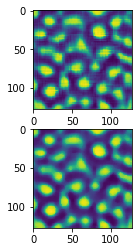

In [9]:
#median filter 
import scipy as sp
from scipy import ndimage

fig, axs = plt.subplots(2, 1)

img = np.reshape(gen_img[34],(128,128))
axs[0].imshow(img)
new_img = ndimage.median_filter(img, 5)
axs[1].imshow(new_img)

torch.Size([100, 1])


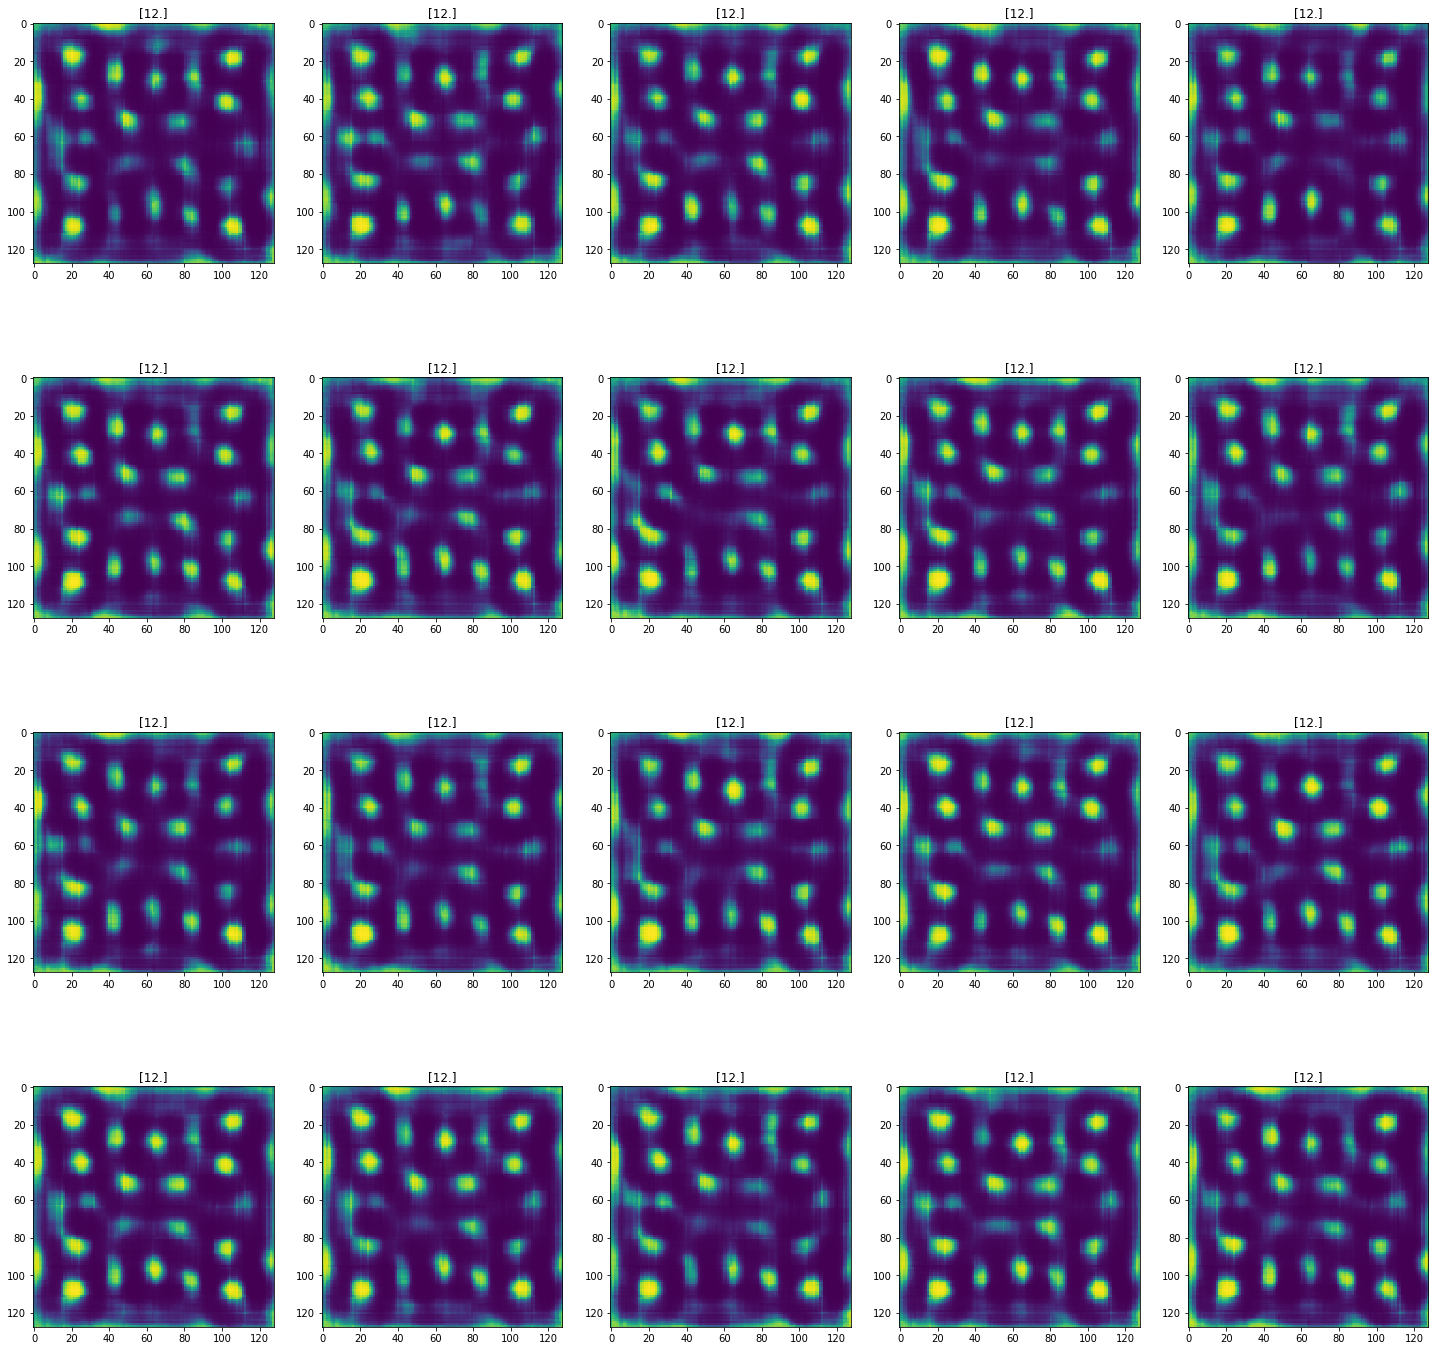

In [8]:
#generate within bounded range 20 sample and check distribution

BATCH_SIZE = 100
noise = gen_rand_noise()
low = 6
high  = 7
Js = []
#J = np.random.uniform(low = low, high = high, size = BATCH_SIZE)
J = np.ones(shape=BATCH_SIZE)*12
Js.append(J)

Js = np.expand_dims(np.ndarray.flatten(np.asarray(Js)), axis=1)
Js = torch.FloatTensor(Js)
print(Js.shape)

gen_img = gen(noise, Js).detach().numpy()

fig, axs = plt.subplots(4, 5, figsize=(25,25))
i=0
j=0
for i in range(4):
    img = np.reshape(gen_img[0+j],(128,128))
    axs[i, 0].imshow(img)
    axs[i, 0].set_title(str(Js[0+j].detach().numpy()))
    
    img = np.reshape(gen_img[1+j],(128,128))
    axs[i, 1].imshow(img)
    axs[i, 1].set_title(str(Js[1+j].detach().numpy()))
    
    img = np.reshape(gen_img[2+j],(128,128))
    axs[i, 2].imshow(img)
    axs[i, 2].set_title(str(Js[2+j].detach().numpy()))
    
    img = np.reshape(gen_img[3+j],(128,128))
    axs[i, 3].imshow(img)
    axs[i, 3].set_title(str(Js[3+j].detach().numpy()))
    
    img = np.reshape(gen_img[4+j],(128,128))
    axs[i, 4].imshow(img)
    axs[i, 4].set_title(str(Js[4+j].detach().numpy()))
    
    j+=5
    
pred_Js = []
for i in range(BATCH_SIZE):
    gen_data = torch.FloatTensor(np.reshape(gen_img[i],(128,128)))
    gen_data = torch.unsqueeze(torch.unsqueeze(gen_data, dim=0), dim=0)
    pred_J = regressor(gen_data)
    pred_Js.append(pred_J.detach().numpy())

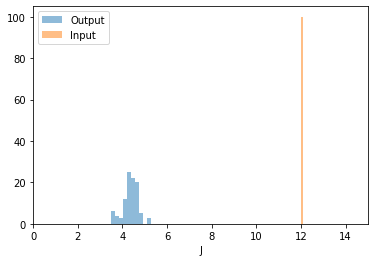

100.0
100.0


In [9]:
#plot densities of control vs predicted
ctrl_J = np.squeeze(Js.detach().numpy(), axis=1).tolist()
counts1, bins1, bars1 = plt.hist(pred_Js, alpha=0.5, density=False, label='Output')
counts2, bins2, bars2 = plt.hist(ctrl_J, alpha=0.5, density=False, label='Input')
#plt.ylabel('Count')
plt.xlabel('J')
plt.xlim(0,15)
plt.legend()
plt.show()

print(sum(counts1))
print(sum(counts2))

In [11]:
#load data and plot distribution of J and pixel values
#ds = np.load('/data/Bernard/DARPA_data/pytorch_data_train.npy', allow_pickle=True)
#ds = np.load('/data/Bernard/DARPA_data/pytorch_balanced_data_train.npy', allow_pickle=True)
ds = np.load('/data/Joshua/DARPA_data/pytorch_data_fixed_flip_train.npy', allow_pickle=True)

(128, 128)


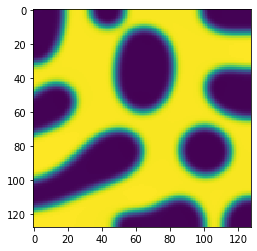

In [12]:
data = ds[:,0]
label = ds[:,1]

print(data[0].shape) # 128, 128
plt.imshow(data[1])

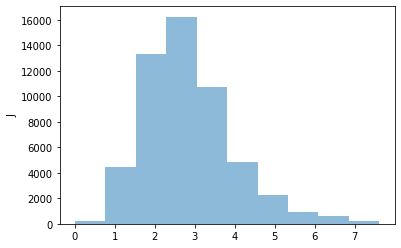

[  236.  4455. 13306. 16234. 10755.  4828.  2294.   939.   588.   225.]
[1.40293735e-316 0.76118 1.52236 2.28354 3.04472 3.8059 4.56708 5.32826
 6.08944 6.850619999999999 7.6118]


In [13]:
#plot densities of real data label
counts, bins, bars = plt.hist(label, alpha=0.5)
plt.ylabel('J')
plt.show()

print(counts)
print(bins)

(112773, 2)


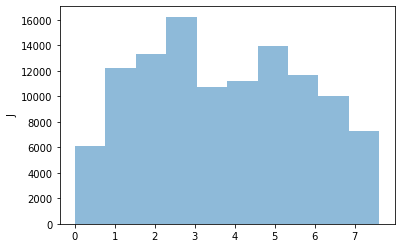

In [14]:
#code block to rebalance dataset with duplicate data
new_ds = ds
idx = np.where(ds[:,1]<1)
for i in range(25):
    for elem in idx:
        new_ds = np.append(new_ds, ds[elem],axis=0)

idx = np.where(ds[:,1]>4)
for i in range(2):
    for elem in idx:
        new_ds = np.append(new_ds, ds[elem],axis=0)

idx = np.where(ds[:,1]>5)
for i in range(9):
    for elem in idx:
        new_ds = np.append(new_ds, ds[elem],axis=0)

idx = np.where(ds[:,1]>6)
for i in range(5):
    for elem in idx:
        new_ds = np.append(new_ds, ds[elem],axis=0)
        
idx = np.where(ds[:,1]>7)
for i in range(22):
    for elem in idx:
        new_ds = np.append(new_ds, ds[elem],axis=0)
    
print(new_ds.shape)
label = new_ds[:,1]
#plot densities of real data label
counts, bins, bars = plt.hist(label, alpha=0.5)
plt.ylabel('J')
plt.show()

np.save('/data/Bernard/DARPA_data/pytorch_balanced_fixed_flip_data_train.npy', new_ds)